In [ ]:
# 50k TASK 목록 (두 개)
TASK = [
    "CLASSIFICATION",
    "RETRIEVAL_QUERY",
]

### 50k 성능 CSV 불러오기 (model_performance5_{task}.csv)

In [ ]:
# 1) 경로 설정 + 데이터 로드
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

cwd = Path.cwd()
target_dir = Path(".") if cwd.name == "performance" else Path("performance")
prefix = "model_performance5_"

csv_files = [
    target_dir / f"{prefix}{t}.csv"
    for t in TASK
    if (target_dir / f"{prefix}{t}.csv").exists()
]
if not csv_files:
    raise FileNotFoundError(
        "model_performance5_{task}.csv 파일을 performance 디렉토리에서 찾지 못했습니다."
    )

agg_rows = []  # Metric, Average, Std. Deviation, task_type
run_rows = []  # Metric, run_idx, value, task_type

for p in csv_files:
    df = pd.read_csv(p, encoding="utf-8-sig")
    df.columns = [c.strip() for c in df.columns]
    # 표준편차 컬럼명 정규화
    if "Std. Deviation" not in df.columns:
        if "Std Deviation" in df.columns:
            df = df.rename(columns={"Std Deviation": "Std. Deviation"})
        elif "Std" in df.columns:
            df = df.rename(columns={"Std": "Std. Deviation"})
    task_type = p.stem.replace(prefix, "")

    # 집계 데이터
    keep = ["Metric", "Average"] + (
        ["Std. Deviation"] if "Std. Deviation" in df.columns else []
    )
    for _, r in df[keep].iterrows():
        row = {k: r[k] for k in keep}
        row["task_type"] = task_type
        agg_rows.append(row)

    # 5회 런 데이터
    run_cols = [c for c in df.columns if c.lower().startswith("run ")]
    for _, r in df[["Metric"] + run_cols].iterrows():
        for rc in run_cols:
            run_rows.append(
                {
                    "Metric": r["Metric"],
                    "run_idx": rc,
                    "value": float(r[rc]),
                    "task_type": task_type,
                }
            )

agg_df = pd.DataFrame(agg_rows)
runs_df = pd.DataFrame(run_rows)
metric_order = ["RMSE", "MAE"]

### RMSE/MAE: 평균 막대 + 표준편차 에러바 + 5회 산점도

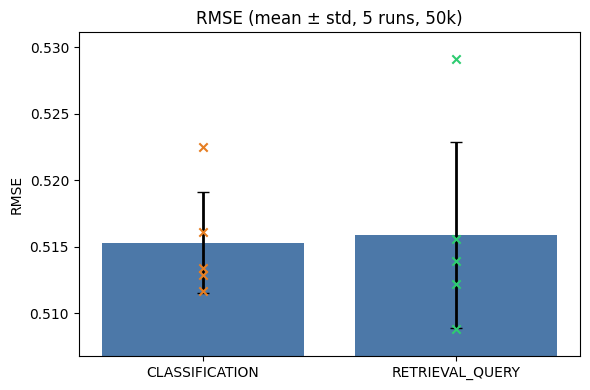

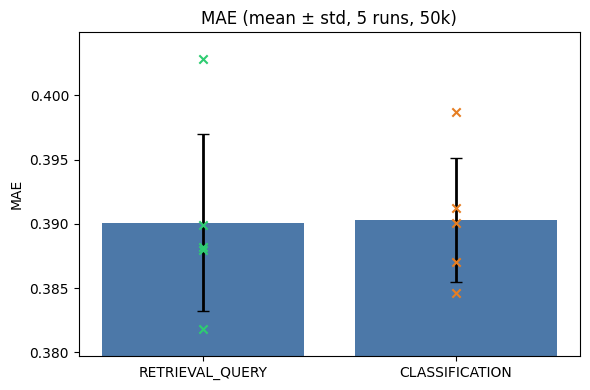

In [ ]:
colors = {
    TASK[0]: "#E67E22",  # orange for scatter
    (TASK[1] if len(TASK) > 1 else "T2"): "#2ECC71",  # green
}

for metric in [m for m in metric_order if m in agg_df["Metric"].unique()]:
    sub = agg_df[agg_df["Metric"] == metric].copy()
    # 값이 낮은 순서로 정렬
    sub = sub.sort_values(["Average", "task_type"])
    order = list(sub["task_type"])

    x = list(range(len(order)))
    means = sub["Average"].astype(float).values
    errs = (
        sub["Std. Deviation"].astype(float).values
        if "Std. Deviation" in sub.columns
        else None
    )

    fig = plt.figure(figsize=(6, 4))
    err_kw = dict(elinewidth=2, ecolor="black", capsize=4)
    plt.bar(x, means, color="#4C78A8", yerr=errs, error_kw=err_kw)

    # 5회 산점도 오버레이
    for i, t in enumerate(order):
        runs = runs_df[(runs_df["Metric"] == metric) & (runs_df["task_type"] == t)]
        if not runs.empty:
            plt.scatter(
                [x[i]] * len(runs),
                runs["value"].astype(float).values,
                s=36,
                marker="x",
                color=colors.get(t, "#FF7F0E"),
                zorder=3,
            )

    plt.xticks(x, order, rotation=0)
    plt.ylabel(metric)
    plt.title(f"{metric} (mean ± std, 5 runs, 50k)")

    # y축 범위: 평균±표준편차와 런 값들을 고려하여 마진 설정
    y_min = float(min(means))
    y_max = float(max(means))
    if errs is not None:
        y_min = min(y_min, float(min(means - errs)))
        y_max = max(y_max, float(max(means + errs)))
    r_sub = runs_df[(runs_df["Metric"] == metric) & (runs_df["task_type"].isin(order))]
    if not r_sub.empty:
        y_min = min(y_min, float(r_sub["value"].min()))
        y_max = max(y_max, float(r_sub["value"].max()))
    rng = max(1e-6, y_max - y_min)
    pad = rng * 0.1
    plt.ylim(y_min - pad, y_max + pad)

    plt.tight_layout()
    out = target_dir / f"bar_runs_{metric}_50k.png"
    plt.savefig(out, dpi=150)
    plt.show()
    plt.close(fig)